In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from common.layers import *
from collections import OrderedDict
from common.gradient import numerical_gradient

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(60000,)


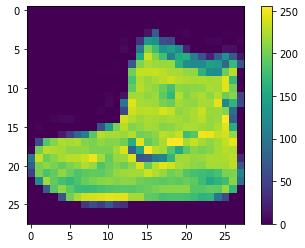

In [2]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [3]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
print(X_train.max())
print(X_test.max())

1.0
1.0


In [4]:
num = np.unique(y_train, axis=0)
num = num.shape[0]
y_train = np.eye(num)[y_train]
print()

In [5]:
num = np.unique(y_test, axis=0)
num = num.shape[0]
y_test = np.eye(num)[y_test]

In [6]:
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [7]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [8]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [9]:
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [10]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x) 
        y = np.argmax(y, axis=1)
        if t.ndim != 1 :
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        return grads
    
    def gradient(self, x, t):
        # foward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        return grads

In [11]:
network = TwoLayerNet(input_size=784, hidden_size1=200, hidden_size2=100, output_size=10)
optimizer = SGD()

In [12]:
iters_num = 10000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

In [13]:
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    params = network.params
    optimizer.update(params, grad)
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('i: {:4d}\tTrain acc: {:.5f}\tTest acc: {:.5f}\tLoss: {:f}'.format(i,train_acc,test_acc,loss))

i:    0	Train acc: 0.10000	Test acc: 0.10000	Loss: 2.301985
i:  600	Train acc: 0.73168	Test acc: 0.72480	Loss: 0.615037
i: 1200	Train acc: 0.83243	Test acc: 0.82060	Loss: 0.469899
i: 1800	Train acc: 0.84605	Test acc: 0.83200	Loss: 0.360114
i: 2400	Train acc: 0.85258	Test acc: 0.83350	Loss: 0.291699
i: 3000	Train acc: 0.87128	Test acc: 0.85630	Loss: 0.346976
i: 3600	Train acc: 0.87493	Test acc: 0.85820	Loss: 0.243624
i: 4200	Train acc: 0.87653	Test acc: 0.86240	Loss: 0.231938
i: 4800	Train acc: 0.87548	Test acc: 0.85900	Loss: 0.275351
i: 5400	Train acc: 0.88488	Test acc: 0.86640	Loss: 0.159214
i: 6000	Train acc: 0.89037	Test acc: 0.86910	Loss: 0.244227
i: 6600	Train acc: 0.87968	Test acc: 0.85510	Loss: 0.263417
i: 7200	Train acc: 0.89460	Test acc: 0.87060	Loss: 0.162157
i: 7800	Train acc: 0.89828	Test acc: 0.87060	Loss: 0.304894
i: 8400	Train acc: 0.90668	Test acc: 0.88000	Loss: 0.219822
i: 9000	Train acc: 0.89238	Test acc: 0.86310	Loss: 0.181725
i: 9600	Train acc: 0.90425	Test acc: 0.8

<function matplotlib.pyplot.show(*args, **kw)>

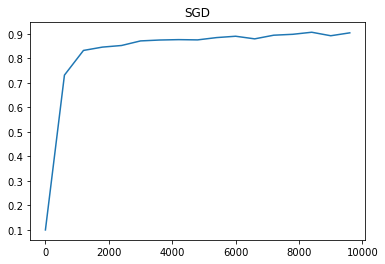

In [15]:
plt.plot(np.arange(0, 10000, 600), train_acc_list)
plt.title('SGD')
plt.show